In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make a Mock ECO Survey

In [2]:
# get path to mocks
import os
cwd = os.getcwd()
data_path = os.path.abspath(os.path.join(os.path.dirname(cwd), 'mocks')) + '/'

In [3]:
from astropy.table import Table
mock = Table.read(data_path + 'mock_1.hdf5', path='data')

In [4]:
from eco_mocks.utils import random_survey
new_mock = random_survey(mock)

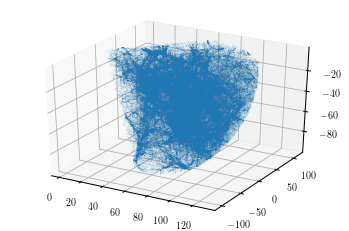

In [15]:
r = np.sqrt(new_mock['x']**2+new_mock['y']**2+new_mock['z']**2)
mask = r<130.0

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(new_mock['x'][mask], new_mock['y'][mask], new_mock['z'][mask], '.', alpha=0.1, ms=0.1)
plt.show()

In [7]:
from eco_mocks.utils import pad_box
coords = np.vstack((mock['x'],mock['y'],mock['z'])).T
new_coords, inds = pad_box(coords)

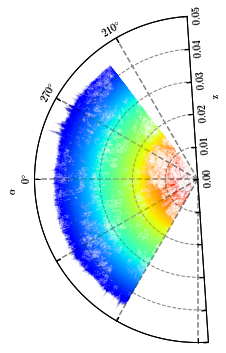

In [48]:
fig = plt.figure(figsize=(3.3, 6.6))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.85)
ax = fractional_polar_axes(fig, rlim=(0,0.05),thlim=(93.75,273.75))
ax.grid(True)
ra = new_mock['ra'][mask]+180.0
z = new_mock['redshift'][mask]
c = new_mock['redshift'][mask]
ax.scatter(ra, z, c=c, marker='.', lw=0, s=1,alpha=0.1,\
           cmap='jet_r', rasterized=True)
plt.show()

In [46]:
def fractional_polar_axes(f, thlim=(0, 180), rlim=(0, 1), step=(30, 0.01),
                          thlabel=r'$\alpha$', rlabel='z', ticklabels=True):
    import matplotlib.pyplot as plt
    
    from matplotlib.transforms import Affine2D
    from matplotlib.projections import PolarAxes
    from mpl_toolkits.axisartist import angle_helper
    from mpl_toolkits.axisartist.grid_finder import MaxNLocator
    from mpl_toolkits.axisartist.floating_axes import GridHelperCurveLinear, FloatingSubplot
    from mpl_toolkits.axisartist.grid_finder import (FixedLocator, MaxNLocator,
                                                 DictFormatter)
    
    """Return polar axes that adhere to desired theta (in deg) and r limits. steps for theta
    and r are really just hints for the locators. Using negative values for rlim causes
    problems for GridHelperCurveLinear for some reason"""
    th0, th1 = thlim # deg
    r0, r1 = rlim
    thstep, rstep = step

    # scale degrees to radians:
    tr_scale = Affine2D().scale(np.pi/180., 1.)
    tr = tr_scale + PolarAxes.PolarTransform()
    theta_grid_locator = angle_helper.LocatorDMS((th1-th0) // thstep)
    r_grid_locator = MaxNLocator((r1-r0) // rstep)
    theta_tick_formatter = angle_helper.FormatterDMS()
    theta_tick_formatter = None
    theta_ticks = [(0, r"$90^{\circ}$"),
                   (30, r"$120^{\circ}$"),
                   (60, r"$150^{\circ}$"),
                   (90, r"$180^{\circ}$"),
                   (120, r"$210^{\circ}$"),
                   (150, r"$270^{\circ}$"),
                   (180, r"$0^{\circ}$")]
    theta_tick_formatter = DictFormatter(dict(theta_ticks))
    grid_helper = GridHelperCurveLinear(tr,
                                        extremes=(th0, th1, r0, r1),
                                        grid_locator1=theta_grid_locator,
                                        grid_locator2=r_grid_locator,
                                        tick_formatter1=theta_tick_formatter,
                                        tick_formatter2=None)

    a = FloatingSubplot(f, 111, grid_helper=grid_helper)
    f.add_subplot(a)

    # adjust x axis (theta):
    a.axis["bottom"].set_visible(False)
    a.axis["top"].set_axis_direction("bottom") # tick direction
    a.axis["top"].toggle(ticklabels=ticklabels, label=bool(thlabel))
    a.axis["top"].major_ticklabels.set_axis_direction("top")
    a.axis["top"].label.set_axis_direction("top")

    # adjust y axis (r):
    a.axis["left"].set_axis_direction("bottom") # tick direction
    a.axis["right"].set_axis_direction("top") # tick direction
    a.axis["left"].toggle(ticklabels=ticklabels, label=bool(rlabel))

    # add labels:
    a.axis["top"].label.set_text(thlabel)
    a.axis["left"].label.set_text(rlabel)
    
    # create a parasite axes whose transData is theta, r:
    auxa = a.get_aux_axes(tr)
    # make aux_ax to have a clip path as in a?:
    auxa.patch = a.patch 
    # this has a side effect that the patch is drawn twice, and possibly over some other
    # artists. So, we decrease the zorder a bit to prevent this:
    a.patch.zorder = -2

    # add sector lines for both dimensions:
    thticks = grid_helper.grid_info['lon_info'][0]
    rticks = grid_helper.grid_info['lat_info'][0]
    for th in thticks[1:-1]: # all but the first and last
        auxa.plot([th, th], [r0, r1], '--', c='grey', zorder=-1)
    for ri, r in enumerate(rticks):
        # plot first r line as axes border in solid black only if it isn't at r=0
        if ri == 0 and r != 0:
            ls, lw, color = 'solid', 2, 'black'
        else:
            ls, lw, color = 'dashed', 1, 'grey'
        # From http://stackoverflow.com/a/19828753/2020363
        auxa.add_artist(plt.Circle([0, 0], radius=r, ls=ls, lw=lw, color=color, fill=False,
                        transform=auxa.transData._b, zorder=-1))
    
    return auxa
